In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from matplotlib import rc
from numpy import inf

from ROOT import TLatex

rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

Welcome to JupyROOT 6.22/02


In [2]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [4]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [111]:
def applyCuts(df,isMC=False):
    temp = df
    temp.eval('theta_lab = arccos(Pz/P)*180.0/3.14159',inplace=True)
    temp.eval('inelasticity = Nu/5.014', inplace=True)
    temp.eval('E = sqrt(P*P+0.1396*0.1396)', inplace=True)
    if(isMC):
        print ('MC')
    else:
        print ('Data')
        temp.eval('pass_reco=1',inplace=True)

    temp = applyCut(temp, 'TargType==1','TargetType==1')
    temp = applyCut(temp, 'pass_reco==0 | inelasticity<0.85','inelasticity < 0.85')
    temp = applyCut(temp, 'pass_reco==0 | (theta_lab<120 and theta_lab>10)', '10<theta_lab<120')
    temp = applyCut(temp, 'pass_reco==0 | (P>0.200)', 'P>0.200')
    temp = applyCut(temp,'pass_reco==0 |(PID==211)| (PID==-211 & theta_lab>30)| (PID==-211 & theta_lab<30 & P>0.600)','(PID==211)| (PID==-211 & theta_lab>30)| (PID==-211 & theta_lab<30 & P>0.600)')
    print('################\n')
    return temp

In [106]:
path = '/home/miguel/EG2_DATA/sebastian/'
data_hadron = root_pandas.read_root(path+'C.root', "ntuple_data")

## obtain MC

In [107]:
path = '/home/miguel/EG2_DATA/andres/'
mc_hadron = root_pandas.read_root(path+'D_weighted.root', "ntuple_sim")

In [108]:
data_hadron['z'] = data_hadron['Zh']


## Apply cuts

In [112]:
data= applyCuts(data_hadron, isMC=False)
mc= applyCuts(mc_hadron, isMC=True)

Data
TargetType==1 8582819  fraction kept: 49.1
inelasticity < 0.85 8579700  fraction kept: 100.0
10<theta_lab<120 8337414  fraction kept: 97.2
P>0.200 8146068  fraction kept: 97.7
(PID==211)| (PID==-211 & theta_lab>30)| (PID==-211 & theta_lab<30 & P>0.600) 8125520  fraction kept: 99.7
################

MC
TargetType==1 865293  fraction kept: 10.2
inelasticity < 0.85 865293  fraction kept: 100.0
10<theta_lab<120 830873  fraction kept: 96.0
P>0.200 805650  fraction kept: 97.0
(PID==211)| (PID==-211 & theta_lab>30)| (PID==-211 & theta_lab<30 & P>0.600) 804865  fraction kept: 99.9
################



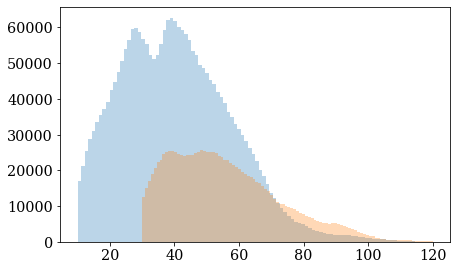

In [113]:
plt.hist(data.query('PID==211 and P<0.6')['theta_lab'],bins=100,alpha=0.3)
plt.hist(data.query('PID==-211 and P<0.6')['theta_lab'],bins=100,alpha=0.3)

plt.show()

## pT vs z 

z>0.00 and z<0.20 and PID==211
z>0.20 and z<0.40 and PID==211
z>0.40 and z<0.60 and PID==211
z>0.60 and z<0.80 and PID==211
z>0.80 and z<1.00 and PID==211


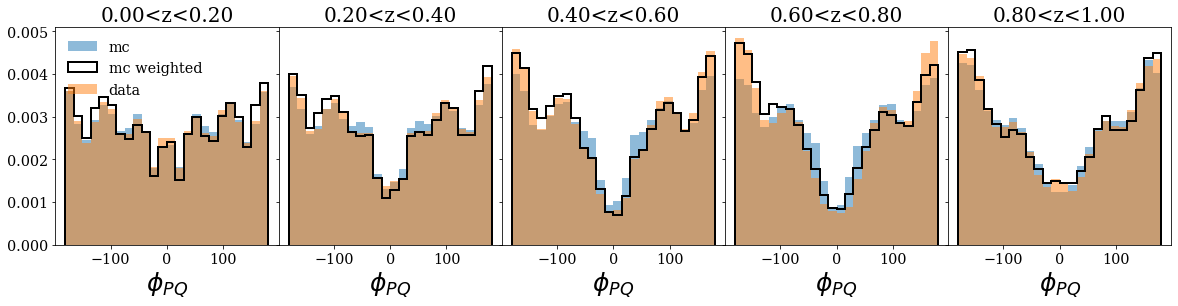

In [29]:
fig, axs = plt.subplots(1, 5, sharey=True, sharex=True, figsize=(20,4), gridspec_kw={'hspace': 0, 'wspace':0})


Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

for j, ibin in enumerate(bins):
    binning = np.linspace(-180, 180, 25)

    query = 'z>%2.2f and z<%2.2f and PID==211'%(ibin[0],ibin[1])
    axs[j].hist(mc.query(query)['PhiPQ'],density=True,bins=binning,alpha=0.5,label='mc')
    axs[j].hist(mc.query(query)['PhiPQ'],bins=binning,weights = mc.query(query)['weight_reco'],**plot_style_1,label='mc weighted')
    axs[j].hist(data.query(query)['PhiPQ'],density=True,bins=binning,alpha=0.5,label='data')

    axs[j].set_title('%2.2f<z<%2.2f'%(ibin[0],ibin[1]),fontsize=20)
    axs[j].set_xlabel(r'$\phi_{PQ}$',fontsize=25)

#axs[j].set_yscale('log')

    print(query)
axs[0].legend(frameon=False,loc='best')


z>0.00 and z<0.20 and PID==211
z>0.20 and z<0.40 and PID==211
z>0.40 and z<0.60 and PID==211
z>0.60 and z<0.80 and PID==211
z>0.80 and z<1.00 and PID==211


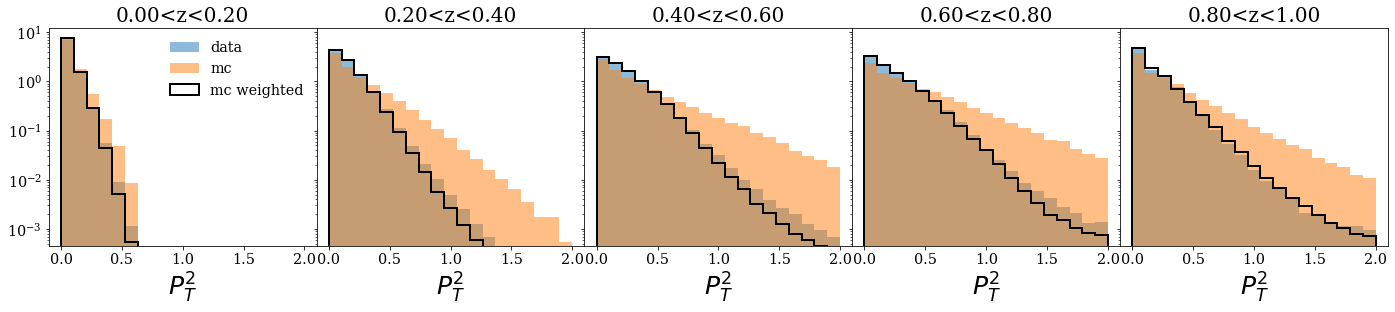

In [30]:
fig, axs = plt.subplots(1, 5, sharey=True, sharex=True, figsize=(24,4), gridspec_kw={'hspace': 0, 'wspace':0})


Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

for j, ibin in enumerate(bins):
    binning = np.linspace(0, 2.0, 20)

    query = 'z>%2.2f and z<%2.2f and PID==211'%(ibin[0],ibin[1])
    axs[j].hist(mc.query(query)['Pt2'],density=True,bins=binning,alpha=0.5,label='mc')
    axs[j].hist(mc.query(query)['Pt2'],bins=binning,weights = mc.query(query)['weight_reco'],**plot_style_1,label='mc weighted')
    axs[j].hist(data.query(query)['Pt2'],density=True,bins=binning,alpha=0.5,label='data')

    axs[j].set_title('%2.2f<z<%2.2f'%(ibin[0],ibin[1]),fontsize=20)
    axs[j].set_xlabel(r'$P_{T}^{2}$',fontsize=25)


    print(query)
axs[0].legend(frameon=False,loc='best')
axs[0].set_yscale('log')


z>0.00 and z<0.20 and PID==211
z>0.20 and z<0.40 and PID==211
z>0.40 and z<0.60 and PID==211
z>0.60 and z<0.80 and PID==211
z>0.80 and z<1.00 and PID==211


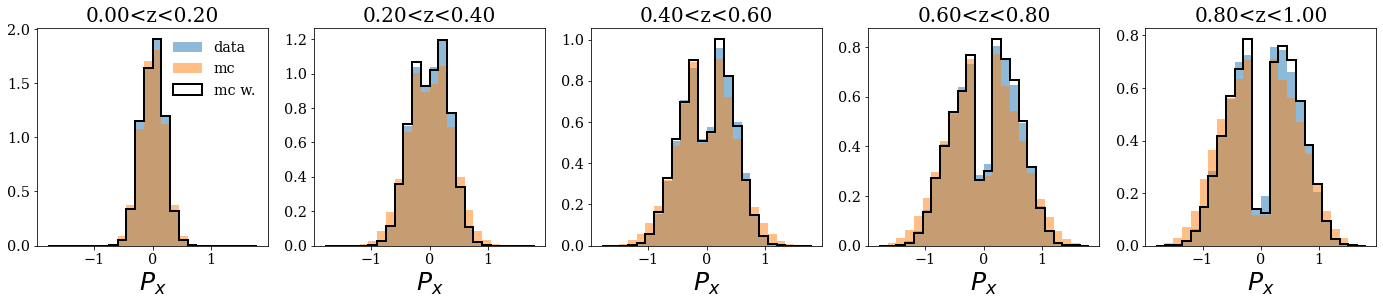

In [31]:
fig, axs = plt.subplots(1, 5, sharex=True,figsize=(24,4))


Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

for j, ibin in enumerate(bins):
    binning = np.linspace(-1.8, 1.8, 25)

    query = 'z>%2.2f and z<%2.2f and PID==211'%(ibin[0],ibin[1])
    axs[j].hist(mc.query(query)['Px'],density=True,bins=binning,alpha=0.5,label='mc')
    axs[j].hist(mc.query(query)['Px'],bins=binning,weights = mc.query(query)['weight_reco'],**plot_style_1,label='mc w.')
    axs[j].hist(data.query(query)['Px'],density=True,bins=binning,alpha=0.5,label='data')

    axs[j].set_title('%2.2f<z<%2.2f'%(ibin[0],ibin[1]),fontsize=20)
    axs[j].set_xlabel(r'$P_{x}$',fontsize=25)


    print(query)
axs[0].legend(frameon=False,loc='best')
#axs[0].set_yscale('log')


z>0.00 and z<0.20 and PID==211
z>0.20 and z<0.40 and PID==211
z>0.40 and z<0.60 and PID==211
z>0.60 and z<0.80 and PID==211
z>0.80 and z<1.00 and PID==211


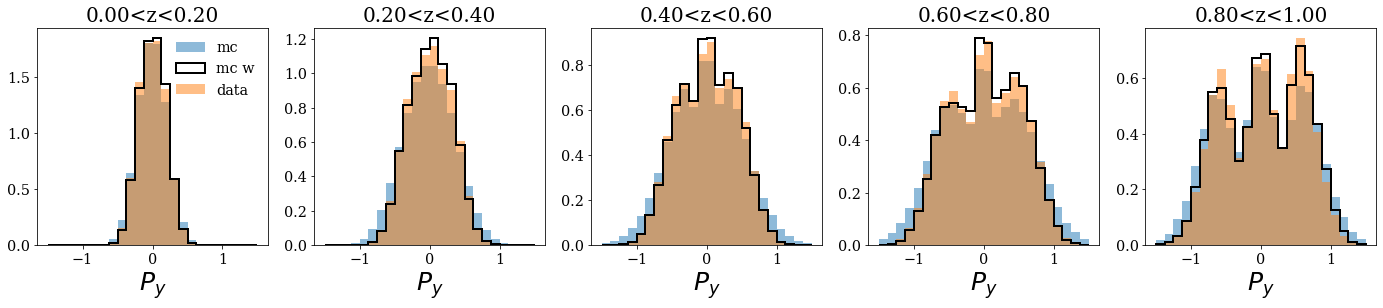

In [32]:
fig, axs = plt.subplots(1, 5, sharex=True, figsize=(24,4))


Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

for j, ibin in enumerate(bins):
    binning = np.linspace(-1.5, 1.5, 25)

    query = 'z>%2.2f and z<%2.2f and PID==211'%(ibin[0],ibin[1])
    axs[j].hist(mc.query(query)['Py'],density=True,bins=binning,alpha=0.5,label='mc')
    axs[j].hist(mc.query(query)['Py'],bins=binning,weights = mc.query(query)['weight_reco'],**plot_style_1,label='mc w')
    axs[j].hist(data.query(query)['Py'],density=True,bins=binning,alpha=0.5,label='data')

    axs[j].set_title('%2.2f<z<%2.2f'%(ibin[0],ibin[1]),fontsize=20)
    axs[j].set_xlabel(r'$P_{y}$',fontsize=25)


    print(query)
axs[0].legend(frameon=False,loc='best')
#axs[0].set_yscale('log')


z>0.00 and z<0.20 and PID==211
z>0.20 and z<0.40 and PID==211
z>0.40 and z<0.60 and PID==211
z>0.60 and z<0.80 and PID==211
z>0.80 and z<1.00 and PID==211


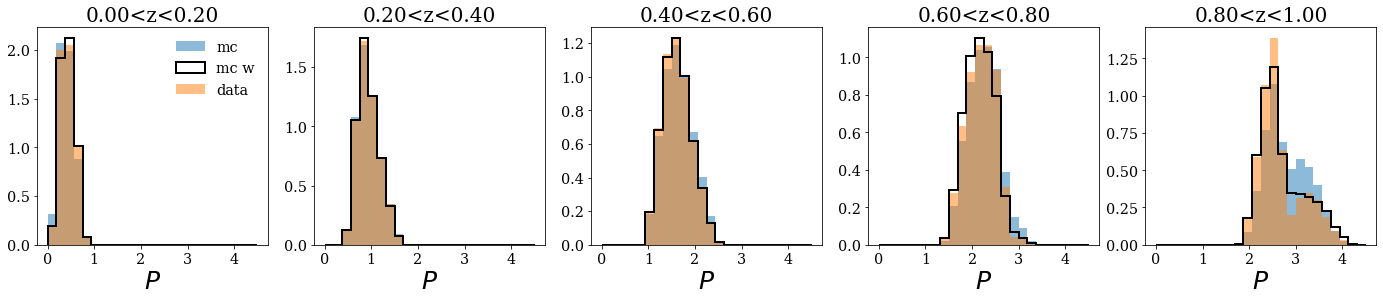

In [33]:
fig, axs = plt.subplots(1, 5, sharex=True, figsize=(24,4))


Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

for j, ibin in enumerate(bins):
    binning = np.linspace(0.0, 4.5, 25)

    query = 'z>%2.2f and z<%2.2f and PID==211'%(ibin[0],ibin[1])
    axs[j].hist(mc.query(query)['P'],density=True,bins=binning,alpha=0.5,label='mc')
    axs[j].hist(mc.query(query)['P'],bins=binning,weights = mc.query(query)['weight_reco'],**plot_style_1,label='mc w')
    axs[j].hist(data.query(query)['P'],density=True,bins=binning,alpha=0.5,label='data')

    axs[j].set_title('%2.2f<z<%2.2f'%(ibin[0],ibin[1]),fontsize=20)
    axs[j].set_xlabel(r'$P$',fontsize=25)


    print(query)
axs[0].legend(frameon=False,loc='best')
#axs[0].set_yscale('log')


z>0.00 and z<0.20 and PID==211
z>0.20 and z<0.40 and PID==211
z>0.40 and z<0.60 and PID==211
z>0.60 and z<0.80 and PID==211
z>0.80 and z<1.00 and PID==211


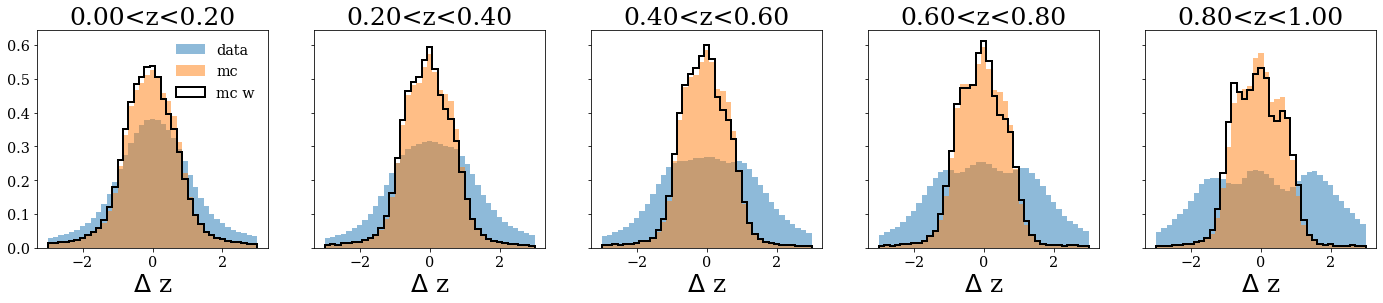

In [23]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(24,4))


Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

for j, ibin in enumerate(bins):
    binning = np.linspace(-3.0,3.0 , 40)

    query = 'z>%2.2f and z<%2.2f and PID==211'%(ibin[0],ibin[1])
    axs[j].hist(mc.query(query)['deltaZ'],density=True,bins=binning,alpha=0.5,label='mc')
    axs[j].hist(mc.query(query)['deltaZ'],bins=binning,weights = mc.query(query)['weight_reco'],**plot_style_1,label='mc w')
    axs[j].hist(data.query(query)['deltaZ'],density=True,bins=binning,alpha=0.5,label='data')

    axs[j].set_title('%2.2f<z<%2.2f'%(ibin[0],ibin[1]),fontsize=25)
    axs[j].set_xlabel(r'$\Delta$ z',fontsize=25)


    print(query)
axs[0].legend(frameon=False,loc='best')
#axs[0].set_yscale('log')



z>0.00 and z<0.20 and PID==211
z>0.20 and z<0.40 and PID==211
z>0.40 and z<0.60 and PID==211
z>0.60 and z<0.80 and PID==211
z>0.80 and z<1.00 and PID==211


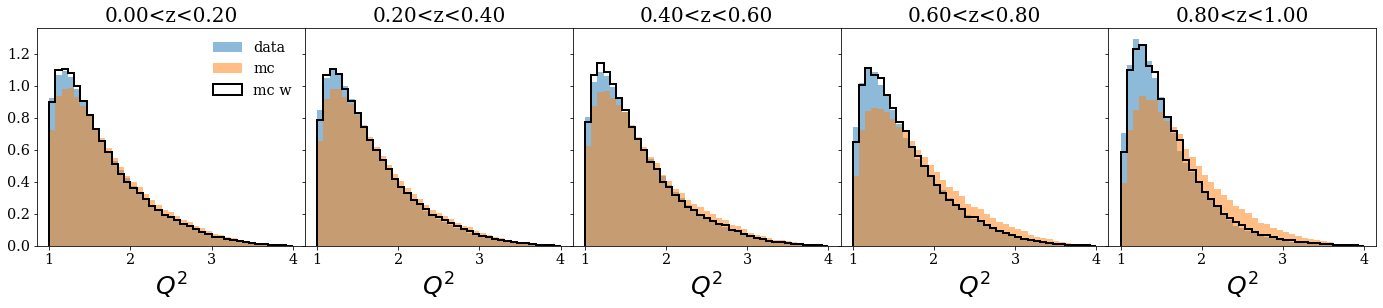

In [21]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(24,4),gridspec_kw={'hspace': 0, 'wspace':0})


Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

for j, ibin in enumerate(bins):
    binning = np.linspace(1.0,4.0 , 40)

    query = 'z>%2.2f and z<%2.2f and PID==211'%(ibin[0],ibin[1])
    axs[j].hist(mc.query(query)['Q2'],density=True,bins=binning,alpha=0.5,label='mc')
    axs[j].hist(mc.query(query)['Q2'],bins=binning,weights = mc.query(query)['weight_reco'],**plot_style_1,label='mc w')
    axs[j].hist(data.query(query)['Q2'],density=True,bins=binning,alpha=0.5,label='data')

    axs[j].set_title('%2.2f<z<%2.2f'%(ibin[0],ibin[1]),fontsize=20)
    axs[j].set_xlabel(r'$Q^{2}$',fontsize=25)


    print(query)
axs[0].legend(frameon=False,loc='best')
#axs[0].set_yscale('log')


z>0.00 and z<0.20 and PID==211
z>0.20 and z<0.40 and PID==211
z>0.40 and z<0.60 and PID==211
z>0.60 and z<0.80 and PID==211
z>0.80 and z<1.00 and PID==211


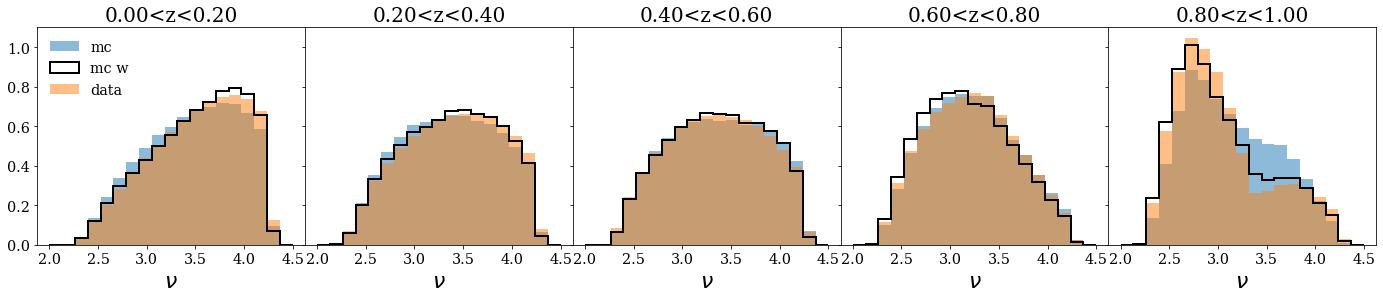

In [26]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(24,4),gridspec_kw={'hspace': 0, 'wspace':0})


Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

for j, ibin in enumerate(bins):
    binning = np.linspace(2.0,4.5 , 20)

    query = 'z>%2.2f and z<%2.2f and PID==211'%(ibin[0],ibin[1])
    axs[j].hist(mc.query(query)['Nu'],density=True,bins=binning,alpha=0.5,label='mc')
    axs[j].hist(mc.query(query)['Nu'],bins=binning,weights = mc.query(query)['weight_reco'],**plot_style_1,label='mc w')
    axs[j].hist(data.query(query)['Nu'],density=True,bins=binning,alpha=0.5,label='data')

    axs[j].set_title('%2.2f<z<%2.2f'%(ibin[0],ibin[1]),fontsize=20)
    axs[j].set_xlabel(r'$\nu$',fontsize=22)


    print(query)
axs[0].legend(frameon=False,loc='best')
#axs[0].set_yscale('log')


## pi-

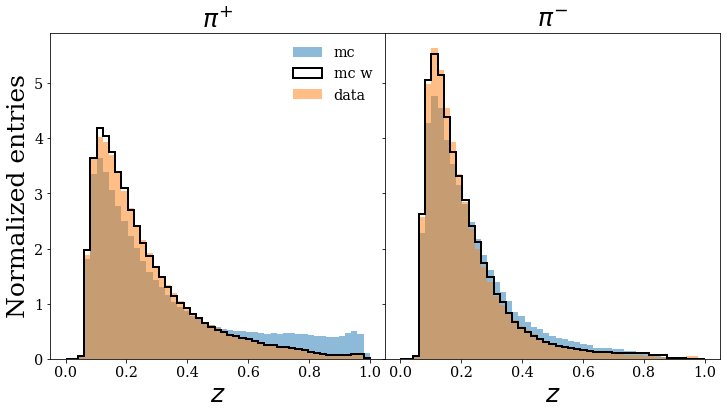

In [89]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6),gridspec_kw={'hspace': 0, 'wspace':0})

binning = np.linspace(0.0, 1.0, 50)
query = 'PID==211'
axs[0].hist(mc.query(query)['z'],density=True,bins=binning,alpha=0.5,label='mc')
axs[0].hist(mc.query(query)['z'],bins=binning,weights = mc.query(query)['weight_reco'],**plot_style_1,label='mc w')
axs[0].hist(data.query(query)['z'],density=True,bins=binning,alpha=0.5,label='data')
#axs[0].set_yscale('log')
axs[0].set_title(r'$\pi^{+}$',fontsize=25)

query = 'PID==-211'
axs[1].hist(mc.query(query)['z'],density=True,bins=binning,alpha=0.5,label='mc')
axs[1].hist(mc.query(query)['z'],bins=binning,weights = mc.query(query)['weight_reco'],**plot_style_1,label='mc w')
axs[1].hist(data.query(query)['z'],density=True,bins=binning,alpha=0.5,label='data')
#axs[1].set_yscale('log')
axs[1].set_title(r'$\pi^{-}$',fontsize=25)
axs[0].set_xlabel(r'$z$',fontsize=25)

axs[1].set_xlabel(r'$z$',fontsize=25)
axs[0].set_ylabel('Normalized entries',fontsize=25)

axs[0].legend(frameon=False,loc='best')


z>0.00 and z<0.20 and PID==-211
z>0.20 and z<0.40 and PID==-211
z>0.40 and z<0.60 and PID==-211
z>0.60 and z<0.80 and PID==-211
z>0.80 and z<1.00 and PID==-211


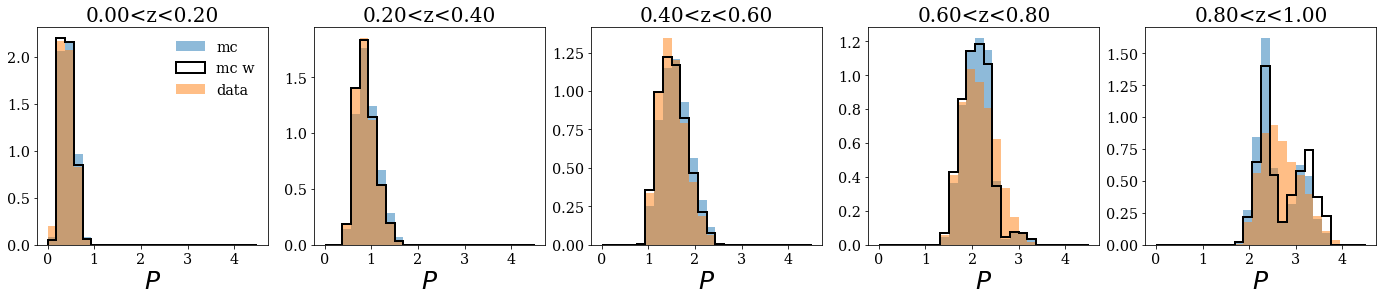

In [34]:
fig, axs = plt.subplots(1, 5, sharex=True, figsize=(24,4))


Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

for j, ibin in enumerate(bins):
    binning = np.linspace(0.0, 4.5, 25)

    query = 'z>%2.2f and z<%2.2f and PID==-211'%(ibin[0],ibin[1])
    axs[j].hist(mc.query(query)['P'],density=True,bins=binning,alpha=0.5,label='mc')
    axs[j].hist(mc.query(query)['P'],bins=binning,weights = mc.query(query)['weight_reco'],**plot_style_1,label='mc w')
    axs[j].hist(data.query(query)['P'],density=True,bins=binning,alpha=0.5,label='data')

    axs[j].set_title('%2.2f<z<%2.2f'%(ibin[0],ibin[1]),fontsize=20)
    axs[j].set_xlabel(r'$P$',fontsize=25)


    print(query)
axs[0].legend(frameon=False,loc='best')
#axs[0].set_yscale('log')

z>0.00 and z<0.20 and PID==-211
z>0.20 and z<0.40 and PID==-211
z>0.40 and z<0.60 and PID==-211
z>0.60 and z<0.80 and PID==-211
z>0.80 and z<1.00 and PID==-211


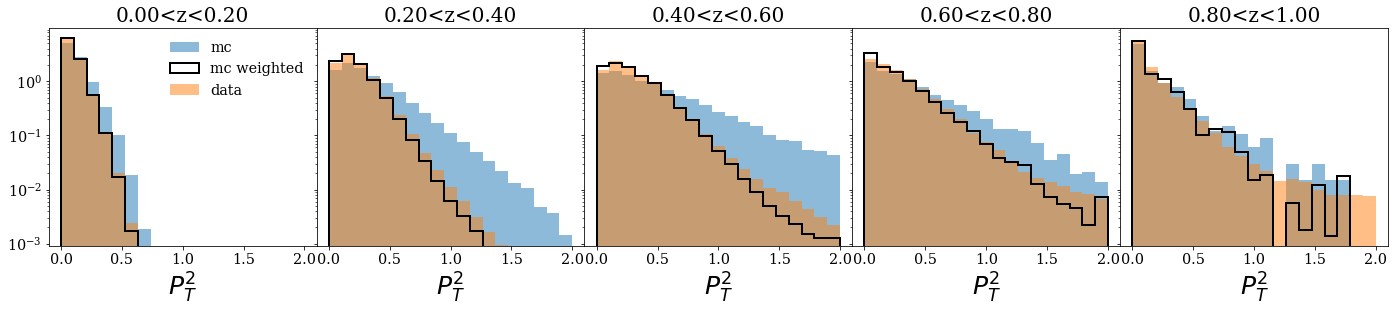

In [35]:
fig, axs = plt.subplots(1, 5, sharey=True, sharex=True, figsize=(24,4), gridspec_kw={'hspace': 0, 'wspace':0})


Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

for j, ibin in enumerate(bins):
    binning = np.linspace(0, 2.0, 20)

    query = 'z>%2.2f and z<%2.2f and PID==-211'%(ibin[0],ibin[1])
    axs[j].hist(mc.query(query)['Pt2'],density=True,bins=binning,alpha=0.5,label='mc')
    axs[j].hist(mc.query(query)['Pt2'],bins=binning,weights = mc.query(query)['weight_reco'],**plot_style_1,label='mc weighted')
    axs[j].hist(data.query(query)['Pt2'],density=True,bins=binning,alpha=0.5,label='data')

    axs[j].set_title('%2.2f<z<%2.2f'%(ibin[0],ibin[1]),fontsize=20)
    axs[j].set_xlabel(r'$P_{T}^{2}$',fontsize=25)


    print(query)
axs[0].legend(frameon=False,loc='best')
axs[0].set_yscale('log')

In [90]:
## Compute efficiency 

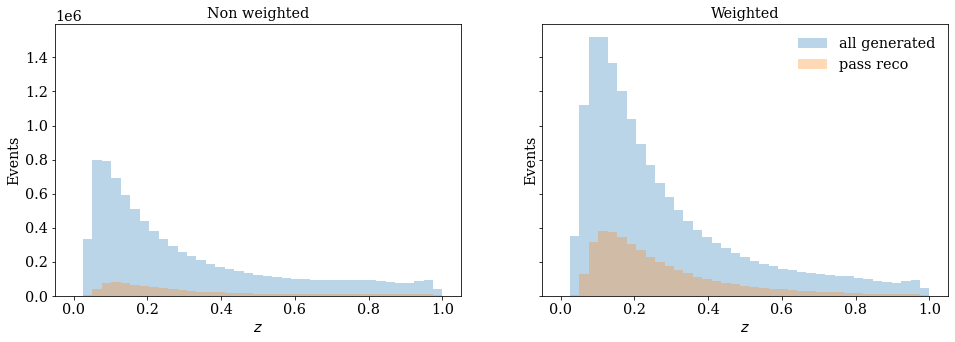

In [129]:
fig, axs = plt.subplots(1,2,figsize=(16,5),sharey=True)

mask = 'pass_reco==1'

bins = np.linspace(0,1.0,40)
axs[0].set_title('Non weighted')
axs[1].set_title('Weighted')
axs[0].hist(mc_hadron['mc_z'],alpha=0.3,bins=bins, label='all generated')
axs[0].hist(mc_hadron.query('pass_reco==1')['mc_z'], alpha=0.3,bins=bins, label='pass reco')

axs[1].hist(mc_hadron.query('pass_truth==1')['mc_z'],alpha=0.3,bins=bins,weights=mc_hadron.query('pass_truth==1')['weight_truth'],label='all generated')
axs[1].hist(mc_hadron.query(mask)['mc_z'],alpha=0.3,bins=bins,weights=mc_hadron.query(mask)['weight_truth'],label='pass reco')


axs[0].set(xlabel=r"$z$", ylabel="Events")
axs[1].set(xlabel=r"$z$", ylabel="Events")
plt.legend()
plt.show()

In [126]:
print('Pass reco ' , np.count_nonzero(mc_hadron['pass_reco']))
print('Pass truth ', np.count_nonzero(mc_hadron['pass_truth']))

print(len(mc_hadron.query('pass_reco==1')))
print(len(mc_hadron))

Pass reco  890885
Pass truth  8500000
890885
8500000


In [100]:
for i in mc_hadron.keys():
    print(i)

Q2
W
Nu
Xb
Yb
vxe
vye
vze
SectorEl
TargType
Pex
Pey
Pez
Pe
BettaEl
Etote
Eine
Eoute
vxec
vyec
vzec
XECe
YECe
ZECe
StatDCEl
DCStatusEl
StatECEl
ECStatusEl
TimeECEl
PathECEl
Chi2ECEl
StatSCEl
SCStatusEl
TimeSCEl
PathSCEl
StatCCEl
CCStatusEl
NpheEl
Chi2CCEl
StatusEl
NRowsDCEl
NRowsECEl
NRowsSCEl
NRowsCCEl
Zh
ThetaPQ
Pt2
Pl2
PhiPQ
Mx2
T
vxh
vyh
vzh
Sector
Px
Py
Pz
P
Betta
Mass2
Etot
Ein
Eout
XEC
YEC
ZEC
pid
T4
deltaZ
StatDC
DCStatus
StatEC
ECStatus
TimeEC
PathEC
Chi2EC
StatSC
SCStatus
TimeSC
PathSC
StatCC
CCStatus
Nphe
Chi2CC
Status
NRowsDC
NRowsEC
NRowsSC
NRowsCC
evnt
mc_Q2
mc_W
mc_Nu
mc_Xb
mc_Yb
mc_vxe
mc_vye
mc_vze
mc_SectorEl
mc_TargType
mc_Pex
mc_Pey
mc_Pez
mc_Pe
mc_BettaEl
mc_Zh
mc_ThetaPQ
mc_Pt2
mc_Pl2
mc_PhiPQ
mc_Mx2
mc_T
mc_vxh
mc_vyh
mc_vzh
mc_Sector
mc_Px
mc_Py
mc_Pz
mc_P
mc_Betta
mc_Mass2
mc_pid
mc_deltaZ
PID
mc_PID
pass_reco
pass_truth
inelasticity
E
z
mc_E
mc_z
weight_reco
weight_truth
theta_lab
